<a href="https://colab.research.google.com/github/summermccune/Tokenization-Testing-for-Malware-Data/blob/main/Tokenization_Malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

### Imports

In [ ]:
!pip install hmmlearn
!pip install datasets

  Using cached hmmlearn-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (161 kB)


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/NSF REU/malware")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
4fams  7fams.csv  7fams_test.csv  7fams_train.csv  Embeddings  Families  Plots	Tokenizers  Tokens


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from collections import Counter
from datasets import load_dataset
from tokenizers.pre_tokenizers import Whitespace
from tokenizers import Tokenizer, ByteLevelBPETokenizer, SentencePieceBPETokenizer
from tokenizers.models import BPE, WordPiece, Unigram
from tokenizers.trainers import BpeTrainer, WordPieceTrainer, UnigramTrainer
from transformers import PreTrainedTokenizerFast
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score, precision_score, recall_score

###Functions

In [ ]:
def saveToCsv(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_csv(pathName+'.csv')
  return df

In [ ]:
def saveToPkl(pathName, labels, data):
  '''
  Saves the data with its labels into a pkl file
  pathName = what pkl file will be named & where it's placed
  '''
  df = pd.DataFrame(list(zip(labels, data)), columns=['Label', 'Opcodes'])
  df.to_pickle(pathName+'.pkl')
  return df

In [ ]:
def readCsvSplit(csvFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_csv(csvFile+'.csv')
  x = df['Opcodes']
  y = df['Label']
  return x, y

In [ ]:
def readPklSplit(pklFile):
  '''
  Reads in the given csv file as dataframe
  Splits the opcodes & labels of dataframe into series
  '''
  df = pd.read_pickle(pklFile+'.pkl')
  x = df['Opcodes']
  y = df['Label']
  return x, y

### Shortcut to read in 4 families saved csv file ###

In [ ]:
all_data = pd.read_csv("7fams.csv")

### Split training/testing data ###

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(all_data['Opcodes'], all_data['Label'], test_size=0.3, random_state=7, stratify=all_data['Label'])
print(y_test.value_counts())
print(y_train.value_counts())
print(x_train.head())
print(y_train.head())
print(x_test.head())
print(y_test.head())

Label
FakeRean       300
Renos          300
Winwebsec      300
Vobfus         300
BHO            300
CeeInject      300
OnLineGames    300
Name: count, dtype: int64
Label
Vobfus         700
BHO            700
Renos          700
CeeInject      700
FakeRean       700
OnLineGames    700
Winwebsec      700
Name: count, dtype: int64
5942    ljmp jae xchg push jae or out push jae add lea...
658     push mov cmpl jne mov leave ret cmpl jne cmpl ...
441     add inc add pop inc outsl outsl insb gs outsb ...
4817    push mov sub mov mov xor cmp ja mov addl orl x...
4997    push mov mov sub mov mov mov mov mov mov mov m...
Name: Opcodes, dtype: object
5942    Vobfus
658        BHO
441        BHO
4817     Renos
4997     Renos
Name: Label, dtype: object
2953    and push mov call add test js mov test mov mov...
2505    sbb add mov xchg mov scas call sub cmp pushw b...
4921    sahf addl add addl add addl add addb adc add a...
6302    add add fs or cltd push or add add add add add...
5564    ljmp jae 

### Saving train/test split to csv files

In [ ]:
saveToCsv('7fams_train', y_train, x_train)
saveToCsv('7fams_test', y_test, x_test)

Label                                            Opcodes
0        FakeRean  and push mov call add test js mov test mov mov...
1        FakeRean  sbb add mov xchg mov scas call sub cmp pushw b...
2           Renos  sahf addl add addl add addl add addb adc add a...
3       Winwebsec  add add fs or cltd push or add add add add add...
4          Vobfus  ljmp jae xchg push jae or out push jae add in ...
...           ...                                                ...
2095    CeeInject  call mov mov mov sub sar mov mov mov mov sub s...
2096  OnLineGames  mov and ret push mov sub andb push push push p...
2097       Vobfus  ljmp jae xchg push jae or out push jae add pop...
2098    CeeInject  call mov mov mov sub sar mov mov mov mov sub s...
2099        Renos  xchg inc lea jmp mov push call call pop in fmu...

[2100 rows x 2 columns]

###Shortcut to read in train/test split csv file

In [ ]:
x_train, y_train = readCsvSplit('7fams_train')
x_test, y_test = readCsvSplit('7fams_test')

### Split/Read in SMALL dataset

In [ ]:
# SPLITTING: FOR THE SAKE OF TESTING OUT CODE: USING ONLY 400/4000 OF DATASET
x_train, x_rest, y_train, y_rest = train_test_split(x_train, y_train, test_size=0.9, random_state=7, stratify=y_train)
x_test, x_rest, y_test, y_rest = train_test_split(x_test, y_test, test_size=0.9, random_state=7, stratify=y_test)

saveToCsv('4fams_small_train', y_train, x_train)
saveToCsv('4fams_small_test', y_test, x_test)

Label                                            Opcodes
0        Vobfus  mov cmp xchg cmp or jae mov cmp add jae jb jae...
1        Vobfus  rcrb add add ja jb lret mov jb lret mov jb lre...
2      FakeRean  or ret int3 int3 int3 int3 int3 mov push mov m...
3        Vobfus  jg mov jb add mov jb xchg mov jb int3 mov jb a...
4     Winwebsec  push mov mov pop ret and sub lret cs hlt in sc...
..          ...                                                ...
75    Winwebsec  push mov sub push mov movl movl movl movl movl...
76       Vobfus  std mov mov jb cmp add jb mov mov jb loopne jb...
77    Winwebsec  shll iret int test sbb insl push pop nop mov l...
78  OnLineGames  mov inc and and add in sub movsl in fnstsw inc...
79     FakeRean  add add add call mov call ret int3 int3 int3 i...

[80 rows x 2 columns]

In [ ]:
# FOR THE SAKE OF TESTING CODE: USE ONLY 400/4000 SAMPLES
x_train, y_train = readCsvSplit('4fams/4fams_small_train')
x_test, y_test = readCsvSplit('4fams/4fams_small_test')
print(y_train.value_counts())
print(y_test.value_counts())

Label
OnLineGames    80
Winwebsec      80
Vobfus         80
FakeRean       80
Name: count, dtype: int64
Label
Vobfus         20
FakeRean       20
Winwebsec      20
OnLineGames    20
Name: count, dtype: int64


## Tokenization Methods

####Single Words: Most common; M=31 (white space separation) ####

#####Defined Functions for topX & removeNonVocab

In [ ]:
# Single Words: Most common; M=31 (white space separation)
def topX(max, series):
  '''
  Finds the top X (max) most commonly occuring tokens in given series
  '''
  ctr = Counter()
  for row in series:
    ctr.update(row.split())
  top_words = [count[0] for count in ctr.most_common(max)]
  return top_words

def removeNonVocab(vocab, series):
  '''
  Removes the words not in the given vocab list from the series
  '''
  rows = []
  vocab_str = '|'.join(vocab)
  pattern = '\\b((?!\\b( |' + vocab_str + ')\\b).)*\\b'
  for row in series:
    row = re.sub(pattern, '', row)
    rows.append(row.split())
  return rows # list of token lists

#####Generate Vocab Dictionary

In [ ]:
T31_vocab = topX(31, x_train)
print(T31_vocab)

['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'dec', 'or', 'cmp', 'xor', 'lea', 'sub', 'and', 'adc', 'sbb', 'test', 'in', 'out', 'movl', 'jmp', 'int3', 'nop', 'ret', 'imul', 'je', 'lods', 'scas', 'stos', 'lret', 'jne']


In [ ]:
T31_vocab = ['add', 'mov', 'push', 'pop', 'inc', 'call', 'xchg', 'dec', 'or', 'cmp', 'xor', 'lea', 'sub', 'and', 'adc', 'sbb', 'test', 'in', 'out', 'movl', 'jmp', 'int3', 'nop', 'ret', 'imul', 'je', 'lods', 'scas', 'stos', 'lret', 'jne']

#####Batch Remove NonVocab from Train

In [ ]:
size = len(x_train)//4
p1 = removeNonVocab(T31_vocab, x_train[:size])

In [ ]:
p2 = removeNonVocab(T31_vocab, x_train[size: size*2])

In [ ]:
p3 = removeNonVocab(T31_vocab, x_train[size*2:size*3])

In [ ]:
p4 = removeNonVocab(T31_vocab, x_train[size*3: size*4])

In [ ]:
# join batched remove lists back together
remain_top31_train = [*p1, *p2, *p3, *p4]
top31_train = saveToPkl('Tokens/T31_train', y_train, remain_top31_train)
print(top31_train.shape)
top31_train.head()

#####Batch Remove NonVocab from Test

In [ ]:
size = len(x_test)//2
p1 = removeNonVocab(T31_vocab, x_test[:size])

In [ ]:
p2 = removeNonVocab(T31_vocab, x_test[size: size*2])

In [ ]:
# join batched remove lists back together
remain_top31_test = [*p1, *p2]
top31_test = saveToPkl('Tokens/T31_test', y_test, remain_top31_test)
print(top31_test.shape)
top31_test.head()

(80, 2)


Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, mov, cmp, add, push,...
1     Vobfus  [add, add, lret, mov, lret, mov, lret, mov, or...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [mov, add, mov, xchg, mov, int3, mov, add, mov...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, in,...

#### Methods for BPE, WPC, UNI, BBPE, SPC

In [ ]:
# General tokenizer & trainer setup
batch_size = 1000
files = {"train": "4fams_small_train.csv", "test": "4fams_small_test.csv"}
dataset = load_dataset("csv", data_files=files)
unk_token = "<UNK>"
spl_tokens = ["<UNK>", "<SEP>", "<MASK>", "<CLS>"]
v_size = 100 # Hyperparameter tuning

def batch_iterator(data):
  # Data refers to either "train" or "test"
  for i in range(0, len(dataset), batch_size):
      yield dataset[data]['Opcodes'][i : i + batch_size]

def prepare_tokenizer_trainer(alg):
    """
    Prepares the tokenizer and trainer with unknown & special tokens
    """
    if alg == 'BPE':
        tokenizer = Tokenizer(BPE(unk_token = unk_token))
        trainer = BpeTrainer(special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'UNI':
        tokenizer = Tokenizer(Unigram())
        trainer = UnigramTrainer(unk_token= unk_token, special_tokens = spl_tokens, vocab_size=v_size)
    elif alg == 'WPC':
        tokenizer = Tokenizer(WordPiece(unk_token = unk_token))
        trainer = WordPieceTrainer(special_tokens = spl_tokens, vocab_size=v_size)

    tokenizer.pre_tokenizer = Whitespace()
    return tokenizer, trainer

def train_tokenizer(alg):
    """
    Trains the tokenizer
    """
    if (alg == 'BPE' or alg == 'UNI' or alg == 'WPC'):
      tokenizer, trainer = prepare_tokenizer_trainer(alg)
      tokenizer.train_from_iterator(batch_iterator('train'), trainer=trainer)
      return tokenizer
    elif alg == 'BBPE':
      tokenizer = ByteLevelBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    elif alg == 'SPC':
      tokenizer = SentencePieceBPETokenizer()
      tokenizer.train_from_iterator(batch_iterator('train'),vocab_size=v_size)
    tokenizer.save("Tokenizers/"+alg+"-trained.json")
    return tokenizer

def encode(tokenizer):
  # FOR THE SAKE OF TESTING: ONLY USE 400/4000 OF DATASET
  train_encode = tokenizer.encode_batch(dataset['train']['Opcodes'])
  train_tokens = [encoding.tokens for encoding in train_encode]
  test_encode = tokenizer.encode_batch(dataset['test']['Opcodes'])
  test_tokens = [encoding.tokens for encoding in test_encode]
  return train_tokens, test_tokens

#### BPE: Character Byte Pair Encoding

In [ ]:
# Train Character BPE tokenizer
BPE_tokenizer = train_tokenizer('BPE')
BPE_tokenizer.save("Tokenizers/BPE-trained.json")

In [ ]:
# Or load in previously trained tokenizer
BPE_tokenizer = Tokenizer.from_file("Tokenizers/BPE-trained.json")

In [ ]:
BPE_train_tokens, BPE_test_tokens = encode(BPE_tokenizer)
print(BPE_train_tokens[0])
print(BPE_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'in', 'sub', 'mov', 'sl', 'in', 'f', 'n', 'st', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'lo', 'c', 'k', 'st', 'o', 's', 'st', 'o', 's', 'st', 'o', 's', 'adc', 'int', 'st', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'jb', 'e', 'mov', 'inc', 'add', 'b', 'r', 'or', 'b', 'd', 'a', 's', 'pop', 'st', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 'st', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'xchg', 'inc', 'inc', 'dec', 'push', 'ret', 'd', 'a', 's', 'dec', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'adc', 'push', 'add', 'adc', 'cmp', 'jn', 'e', 'pop', 'test', 'sbb', 'loop', 'e', 'mov', 'cl', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'lea', 'v', 'e', 'ret', 'xor', 'push', 'cmp', 'mov', 'f', 'i', 'st', 'l', 'pop', 'cl', 'd', 'add', 'or', 'add', 'f', 's', 'l', 'ret', 'in', 'l', 'jmp', 

In [ ]:
# Save tokenized data
BPE_train = saveToPkl('Tokens/BPE_train', dataset['train']['Label'], BPE_train_tokens)
BPE_test = saveToPkl('Tokens/BPE_test', dataset['test']['Label'], BPE_test_tokens)
print(BPE_train.head())
print(BPE_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, in, sub, mov, sl, in...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [or, nop, add, dec, dec, or, adc, l, inc, sub,...
3    Winwebsec  [push, a, xor, add, push, call, add, l, dec, d...
4       Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, p...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, or, j, a, e, mov, cmp, a...
1     Vobfus  [r, c, r, b, add, add, j, a, jb, l, ret, mov, ...
2   FakeRean  [or, ret, int3, int3, int3, int3, int3, mov, p...
3     Vobfus  [j, g, mov, jb, add, mov, jb, xchg, mov, jb, i...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, l, ret, c...


#### WPC: WordPiece ####

In [ ]:
# WordPiece
WPC_tokenizer = train_tokenizer('WPC')
WPC_tokenizer.save("Tokenizers/WPC-trained.json")

In [ ]:
# Or load in previously trained tokenizer
WPC_tokenizer = Tokenizer.from_file("Tokenizers/WPC-trained.json")

In [ ]:
WPC_train_tokens, WPC_test_tokens = encode(WPC_tokenizer)
print(WPC_train_tokens[0])
print(WPC_test_tokens[0])

['mov', 'inc', 'a', '##n', '##d', 'a', '##n', '##d', 'add', 'in', 's', '##u', '##b', 'mov', '##s', '##l', 'in', 'f', '##n', '##s', '##t', '##s', '##w', 'inc', '##l', 'push', 'push', 'push', 'pop', 'x', '##o', '##r', 'le', '##a', 'l', '##o', '##c', '##k', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 's', '##t', '##o', '##s', 'ad', '##c', 'in', '##t', 's', '##t', '##o', '##s', 'add', 'a', '##n', '##d', 'a', '##n', '##d', 'j', '##mp', 'a', '##n', '##d', 't', '##e', '##s', '##t', 'call', 'j', '##b', '##e', 'mov', 'inc', 'add', '##b', 'r', '##o', '##r', '##b', 'd', '##a', '##s', 'pop', 's', '##t', '##i', 'mov', 'push', 'mov', 'le', '##a', 'push', 'a', '##n', '##d', 's', '##b', '##b', 'x', '##o', '##r', 'push', 'pop', 'o', '##u', '##t', 'f', '##u', '##c', '##o', '##m', 'f', '##b', '##s', '##t', '##p', 'j', '##e', 'mov', 'push', 'call', 'push', 'in', 'mov', 'mov', 'pop', 'in', 'inc', 'x', '##c', '##h', '##g', 'inc', 'inc', 'dec', 'push', 'r', '##e', '##t', 'd', '##a', '##s', 'dec', 'pu

In [ ]:
# Save tokenized data
WPC_train = saveToPkl('Tokens/WPC_train', dataset['train']['Label'], WPC_train_tokens)
WPC_test = saveToPkl('Tokens/WPC_test', dataset['test']['Label'], WPC_test_tokens)
print(WPC_train.head())
print(WPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, a, ##n, ##d, a, ##n, ##d, add, in, ...
1    Winwebsec  [a, ##n, ##d, ##l, add, pop, ##a, push, add, p...
2    Winwebsec  [o, ##r, n, ##op, add, dec, dec, o, ##r, ad, #...
3    Winwebsec  [push, ##a, x, ##o, ##r, add, push, call, add,...
4       Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, x, ##c, ##h, ##g, cmp, o, ##r, j, #...
1     Vobfus  [r, ##c, ##r, ##b, add, add, j, ##a, j, ##b, l...
2   FakeRean  [o, ##r, r, ##e, ##t, in, ##t, ##3, in, ##t, #...
3     Vobfus  [j, ##g, mov, j, ##b, add, mov, j, ##b, x, ##c...
4  Winwebsec  [push, mov, mov, pop, r, ##e, ##t, a, ##n, ##d...


#### SPC: SentencePiece ####

In [ ]:
# SentencePiece
SPC_tokenizer = train_tokenizer('SPC')
SPC_tokenizer.save("Tokenizers/SPC-trained.json")

In [ ]:
# Or load in previously trained tokenizer
SPC_tokenizer = Tokenizer.from_file("Tokenizers/SPC-trained.json")

In [ ]:
SPC_train_tokens, SPC_test_tokens = encode(SPC_tokenizer)
print(SPC_train_tokens[0])
print(SPC_test_tokens[0])

['▁mov', '▁inc', '▁and', '▁and', '▁add', '▁in', '▁sub', '▁mov', 's', 'l', '▁in', '▁f', 'n', 'st', 's', 'w', '▁inc', 'l', '▁push', '▁push', '▁push', '▁pop', '▁xor', '▁lea', '▁lo', 'c', 'k', '▁st', 'o', 's', '▁st', 'o', 's', '▁st', 'o', 's', '▁adc', '▁int', '▁st', 'o', 's', '▁add', '▁and', '▁and', '▁j', 'mp', '▁and', '▁test', '▁call', '▁j', 'b', 'e', '▁mov', '▁inc', '▁add', 'b', '▁r', 'or', 'b', '▁d', 'a', 's', '▁pop', '▁st', 'i', '▁mov', '▁push', '▁mov', '▁lea', '▁push', '▁and', '▁sbb', '▁xor', '▁push', '▁pop', '▁out', '▁f', 'u', 'c', 'o', 'm', '▁f', 'b', 'st', 'p', '▁j', 'e', '▁mov', '▁push', '▁call', '▁push', '▁in', '▁mov', '▁mov', '▁pop', '▁in', '▁inc', '▁xchg', '▁inc', '▁inc', '▁dec', '▁push', '▁r', 'et', '▁d', 'a', 's', '▁dec', '▁push', '▁sub', '▁d', 'i', 'v', 'l', '▁push', '▁adc', '▁push', '▁add', '▁adc', '▁cmp', '▁jn', 'e', '▁pop', '▁test', '▁sbb', '▁lo', 'op', 'e', '▁mov', '▁c', 'l', 'c', '▁pop', '▁pop', '▁pop', '▁push', '▁pop', '▁pop', '▁pop', '▁lea', 'v', 'e', '▁r', 'et', '▁xo

In [ ]:
# Save tokenized data
SPC_train = saveToPkl('Tokens/SPC_train', dataset['train']['Label'], SPC_train_tokens)
SPC_test = saveToPkl('Tokens/SPC_test', dataset['test']['Label'], SPC_test_tokens)
print(SPC_train.head())
print(SPC_test.head())

         Label                                            Opcodes
0  OnLineGames  [▁mov, ▁inc, ▁and, ▁and, ▁add, ▁in, ▁sub, ▁mov...
1    Winwebsec  [▁and, l, ▁add, ▁pop, a, ▁push, ▁add, ▁pop, a,...
2    Winwebsec  [▁or, ▁, n, op, ▁add, ▁dec, ▁dec, ▁or, ▁adc, l...
3    Winwebsec  [▁push, a, ▁xor, ▁add, ▁push, ▁call, ▁add, l, ...
4       Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
       Label                                            Opcodes
0     Vobfus  [▁mov, ▁cmp, ▁xchg, ▁cmp, ▁or, ▁j, a, e, ▁mov,...
1     Vobfus  [▁r, c, r, b, ▁add, ▁add, ▁j, a, ▁j, b, ▁l, r,...
2   FakeRean  [▁or, ▁r, et, ▁int, 3, ▁int, 3, ▁int, 3, ▁int,...
3     Vobfus  [▁j, g, ▁mov, ▁j, b, ▁add, ▁mov, ▁j, b, ▁xchg,...
4  Winwebsec  [▁push, ▁mov, ▁mov, ▁pop, ▁r, et, ▁and, ▁sub, ...


#### UNI: Unigram Subword ####

In [ ]:
# Unigram (subword)
UNI_tokenizer = train_tokenizer('UNI')
UNI_tokenizer.save("Tokenizers/UNI-trained.json")

In [ ]:
# Or load in previously trained tokenizer
UNI_tokenizer = Tokenizer.from_file("Tokenizers/UNI-trained.json")

In [ ]:
UNI_train_tokens, UNI_test_tokens = encode(UNI_tokenizer)
print(UNI_train_tokens[0])
print(UNI_test_tokens[0])

['mov', 'inc', 'and', 'and', 'add', 'i', 'n', 'sub', 'movsl', 'i', 'n', 'fnst', 's', 'w', 'inc', 'l', 'push', 'push', 'push', 'pop', 'xor', 'lea', 'l', 'o', 'ck', 's', 't', 'o', 's', 's', 't', 'o', 's', 's', 't', 'o', 's', 'a', 'd', 'c', 'int', 's', 't', 'o', 's', 'add', 'and', 'and', 'jmp', 'and', 'test', 'call', 'j', 'b', 'e', 'mov', 'inc', 'add', 'b', 'r', 'o', 'r', 'b', 'd', 'a', 's', 'pop', 's', 't', 'i', 'mov', 'push', 'mov', 'lea', 'push', 'and', 'sbb', 'xor', 'push', 'pop', 'out', 'f', 'u', 'c', 'o', 'm', 'f', 'b', 's', 't', 'p', 'j', 'e', 'mov', 'push', 'call', 'push', 'i', 'n', 'mov', 'mov', 'pop', 'i', 'n', 'inc', 'xchg', 'inc', 'inc', 'd', 'e', 'c', 'push', 'ret', 'd', 'a', 's', 'd', 'e', 'c', 'push', 'sub', 'd', 'i', 'v', 'l', 'push', 'a', 'd', 'c', 'push', 'add', 'a', 'd', 'c', 'cmp', 'j', 'n', 'e', 'pop', 'test', 'sbb', 'loope', 'mov', 'c', 'l', 'c', 'pop', 'pop', 'pop', 'push', 'pop', 'pop', 'pop', 'leave', 'ret', 'xor', 'push', 'cmp', 'mov', 'fist', 'l', 'pop', 'c', 'l

In [ ]:
# Save tokenized data
UNI_train = saveToPkl('Tokens/UNI_train', dataset['train']['Label'], UNI_train_tokens)
UNI_test = saveToPkl('Tokens/UNI_test', dataset['test']['Label'], UNI_test_tokens)
print(UNI_train.head())
print(UNI_test.head())

         Label                                            Opcodes
0  OnLineGames  [mov, inc, and, and, add, i, n, sub, movsl, i,...
1    Winwebsec  [and, l, add, pop, a, push, add, pop, a, push,...
2    Winwebsec  [o, r, n, o, p, add, d, e, c, d, e, c, o, r, a...
3    Winwebsec  [push, a, xor, add, push, call, add, l, d, e, ...
4       Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
       Label                                            Opcodes
0     Vobfus  [mov, cmp, xchg, cmp, o, r, j, a, e, mov, cmp,...
1     Vobfus  [r, c, r, b, add, add, j, a, j, b, lret, mov, ...
2   FakeRean  [o, r, ret, int, 3, int, 3, int, 3, int, 3, in...
3     Vobfus  [j, g, mov, j, b, add, mov, j, b, xchg, mov, j...
4  Winwebsec  [push, mov, mov, pop, ret, and, sub, lret, c, ...


##Embedding Methods

### Word2Vec Embeddings ###

In [ ]:
# Hyperparameters
v = 100 # vector size
w = 30 # window size

def w2v(train, test):
  model = Word2Vec(train, vector_size=v, window=w)
  train_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in train])
  test_embeddings = np.array([np.mean([model.wv[word] for word in text if word in model.wv], axis=0) for text in test])
  return train_embeddings, test_embeddings


#### Single Words M=31

In [ ]:
# Shortcut to read in tokens
T31_train_tokens, T31_y_train = readPklSplit('Tokens/T31_train')
T31_test_tokens, T31_y_test = readPklSplit('Tokens/T31_test')

In [ ]:
# Single Word M=31
T31_train_w2v, T31_test_w2v = w2v(T31_train_tokens, T31_test_tokens)

In [ ]:
# Save top31 embeddings
saveToPkl('Embeddings/W2v/T31_train_w2v', T31_y_train, T31_train_w2v)
saveToPkl('Embeddings/W2v/T31_test_w2v', T31_y_test, T31_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.31082463, 0.16656592, 0.028407363, -0.54181...
1        Vobfus  [0.36657238, 0.14587696, 0.03810417, -0.414078...
2      FakeRean  [0.5085669, -0.07791692, 0.23427534, -0.301232...
3        Vobfus  [0.369045, 0.13802777, 0.046733998, -0.4543264...
4     Winwebsec  [0.27910164, -0.17563044, -0.04468694, 0.08609...
..          ...                                                ...
75    Winwebsec  [0.39372116, -0.08660598, 0.08423068, -0.44390...
76       Vobfus  [-0.005377842, -0.39217263, 0.5460347, -1.2255...
77    Winwebsec  [0.15215333, -0.045315046, -0.18435964, 0.1800...
78  OnLineGames  [0.0147366, -0.3235951, 0.16420855, -0.5872698...
79     FakeRean  [0.48814103, -0.09193846, 0.25916415, -0.33702...

[80 rows x 2 columns]

#### Character BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readPklSplit("Tokens/BPE_train")
BPE_test_tokens,  BPE_y_test = readPklSplit("Tokens/BPE_test")

In [ ]:
# Character BPE
BPE_train_w2v, BPE_test_w2v = w2v(BPE_train_tokens, BPE_test_tokens)

NameError: name 'BPE_train_tokens' is not defined

In [ ]:
# Save BPE embeddings
saveToPkl('./Embeddings/W2v/BPE_train_w2v', BPE_y_train, BPE_train_w2v)
saveToPkl('./Embeddings/W2v/BPE_test_w2v', BPE_y_test, BPE_test_w2v)

Label                                            Opcodes
0        Vobfus  [0.19384877, -0.13887163, 0.23485179, 0.037182...
1        Vobfus  [0.04090311, -0.23123617, 0.10503036, -0.09103...
2      FakeRean  [0.0338138, -0.15930967, -0.046119623, -0.0252...
3        Vobfus  [0.06531363, -0.22762355, 0.12306846, -0.07574...
4     Winwebsec  [0.08112681, -0.45545503, -0.36866447, -0.4441...
..          ...                                                ...
75    Winwebsec  [0.017986082, -0.7974654, -0.38634524, -0.5025...
76       Vobfus  [0.7511463, 0.9279787, 0.090373024, 1.6379477,...
77    Winwebsec  [0.050656844, -0.088684626, 0.22716565, -0.355...
78  OnLineGames  [0.31798032, 0.45840815, -0.05289732, 0.708383...
79     FakeRean  [0.020853039, -0.12908158, -0.08318295, 0.0402...

[80 rows x 2 columns]

#### WordPiece

In [ ]:
# Shortcut to read in tokens
WPC_train_tokens, WPC_y_train = readPklSplit("Tokens/WPC_train")
WPC_test_tokens,  WPC_y_test = readPklSplit("Tokens/WPC_test")

In [ ]:
# WordPiece
WPC_train_w2v, WPC_test_w2v = w2v(WPC_train_tokens, WPC_test_tokens)

In [ ]:
# Save WordPiece embeddings
saveToPkl('./Embeddings/W2v/WPC_train_w2v', WPC_y_train, WPC_train_w2v)
saveToPkl('./Embeddings/W2v/WPC_test_w2v', WPC_y_test, WPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.1540402, 0.15571289, -0.44724944, -0.81924...
1        Vobfus  [-0.16953048, 0.35688353, -0.40208074, -0.9413...
2      FakeRean  [-0.3233312, 0.3129941, -0.07510721, -0.630887...
3        Vobfus  [-0.16538283, 0.32644066, -0.39600307, -0.8866...
4     Winwebsec  [-0.0053400067, 0.22685331, 0.17713654, -0.479...
..          ...                                                ...
75    Winwebsec  [-0.5315097, 0.584941, 0.30193782, -0.5994048,...
76       Vobfus  [-0.5018635, -0.4904157, 0.03029053, -0.616690...
77    Winwebsec  [-0.28793696, 0.02001566, -0.23961309, -0.5029...
78  OnLineGames  [-0.18904018, -0.14267743, 0.011463068, -0.419...
79     FakeRean  [-0.3428595, 0.28670993, -0.08827966, -0.65260...

[80 rows x 2 columns]

####SentencePiece

In [ ]:
# Shortcut to read in tokens
SPC_train_tokens, SPC_y_train = readPklSplit("Tokens/SPC_train")
SPC_test_tokens,  SPC_y_test = readPklSplit("Tokens/SPC_test")

In [ ]:
# SentencePiece
SPC_train_w2v, SPC_test_w2v = w2v(SPC_train_tokens, SPC_test_tokens)

In [ ]:
# Save SentencePiece embeddings
saveToPkl('./Embeddings/W2v/SPC_train_w2v', SPC_y_train, SPC_train_w2v)
saveToPkl('./Embeddings/W2v/SPC_test_w2v', SPC_y_test, SPC_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.2083771, -0.19124888, 0.339916, -0.3260013...
1        Vobfus  [-0.12041399, -0.28546846, 0.55913615, -0.6030...
2      FakeRean  [-0.06480191, -0.2612142, 0.3677679, -0.405357...
3        Vobfus  [-0.14982717, -0.24604246, 0.45610076, -0.5293...
4     Winwebsec  [0.39961794, -0.1338859, 0.22603856, 0.0238467...
..          ...                                                ...
75    Winwebsec  [-0.089973524, -0.39310372, 0.9888692, -0.7887...
76       Vobfus  [-0.13233256, 0.106318645, -0.634718, 0.107228...
77    Winwebsec  [-0.22535029, -0.003619174, 0.37371024, -0.033...
78  OnLineGames  [0.21541783, 0.092431195, -0.20003465, 0.22956...
79     FakeRean  [-0.07626237, -0.23660831, 0.34208572, -0.3913...

[80 rows x 2 columns]

####Unigram

In [ ]:
# Shortcut to read in tokens
UNI_train_tokens, UNI_y_train = readPklSplit("Tokens/UNI_train")
UNI_test_tokens,  UNI_y_test = readPklSplit("Tokens/UNI_test")

In [ ]:
# Unigram Subword
UNI_train_w2v, UNI_test_w2v = w2v(UNI_train_tokens, UNI_test_tokens)

In [ ]:
# Save Unigram Subword embeddings
saveToPkl('./Embeddings/W2v/UNI_train_w2v', UNI_y_train, UNI_train_w2v)
saveToPkl('./Embeddings/W2v/UNI_test_w2v', UNI_y_test, UNI_test_w2v)

Label                                            Opcodes
0        Vobfus  [-0.6616016, -0.17704597, -0.36743197, 0.59319...
1        Vobfus  [-0.590972, -0.23107593, -0.58176017, 0.764632...
2      FakeRean  [-0.44426015, 0.24354666, -0.41671935, 0.78825...
3        Vobfus  [-0.54443, -0.18773034, -0.5486641, 0.7651026,...
4     Winwebsec  [0.37256694, -0.09654294, -0.12058604, 0.61477...
..          ...                                                ...
75    Winwebsec  [-0.4415757, -0.15916534, -0.6326775, 1.142163...
76       Vobfus  [-1.0041813, 0.68850756, 0.49880323, 0.4237026...
77    Winwebsec  [-0.28853396, 0.13133976, -0.13964999, 0.28848...
78  OnLineGames  [-0.2362623, 0.35394228, 0.3859618, 0.4801382,...
79     FakeRean  [-0.46806073, 0.2775875, -0.40858692, 0.770066...

[80 rows x 2 columns]

### HMM2Vec Embeddings

In [ ]:
# Hyperparameters
n_states = 2 # num of hidden states
iters = 100 # max iters to perform for training HMM
max_feature_length = 62

def h2v(train, test, vocab):
  # use LabelEncoder to encode classes (opcode tokens) to numerical values
  le = LabelEncoder().fit(vocab)
  train = [le.transform(tokens) for tokens in train]
  test = [le.transform(tokens) for tokens in test]
  # find numerical encoding for 'mov', used for B matrix
  mov = le.transform(['mov'])

  # train hmm models for EACH sample & take only B matrices as embeddings
  train_embeddings = hmmEmbed(train, mov)
  test_embeddings = hmmEmbed(test, mov)

  return train_embeddings, test_embeddings

# helper method for training HMM model on opcode sequence & retrieving B-matrix (=embedding)
# add in random restarts code later!!
def hmmEmbed(opcodes, mov):
  embeddings = []
  for sample in opcodes:
    # train HMM model
    model = hmm.CategoricalHMM(n_components=n_states, n_iter=iters)
    sample = np.array(sample)
    model.fit(sample.reshape(-1, 1))

    # find index w/ highest prob for mov & split vector w/ it
    # then flatten B matrix to create HMM2Vec feature vector
    # shape of emission prob = (n_components, n_features)
    mov_index = np.argmax(model.emissionprob_[: ,mov])
    b_matrix = model.emissionprob_[[mov_index, 1 - mov_index]]
    feature_vector = b_matrix.flatten()

    embeddings.append(fixLength(feature_vector))
  return embeddings

# helper method for padding/truncating vectors to fixed max length
def fixLength(feature_vector):
  if len(feature_vector) < max_feature_length:
    feature_vector = np.pad(feature_vector, (0, max_feature_length - len(feature_vector)), mode='constant')
  elif len(feature_vector) > max_feature_length:
    feature_vector = feature_vector[:max_feature_length]
  return feature_vector


####Single Words M=31

In [ ]:
# Shortcut to read in tokens
T31_train_tokens, T31_y_train = readPklSplit('Tokens/T31_train')
T31_test_tokens, T31_y_test = readPklSplit('Tokens/T31_test')

In [ ]:
# Single Word M=31
T31_train_h2v, T31_test_h2v = h2v(T31_train_tokens, T31_test_tokens, T31_vocab)

In [ ]:
# Save HMM2Vec T31 embeddings
saveToPkl('Embeddings/H2v/T31_train_h2v', T31_y_train, T31_train_h2v)
saveToPkl('Embeddings/H2v/T31_test_h2v', T31_y_test, T31_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0029419328820285084, 0.19139620787394954, 0...
1        Vobfus  [1.4810178541044431e-69, 0.029274044030121342,...
2      FakeRean  [0.00204519207661278, 0.15201959998432077, 0.0...
3        Vobfus  [2.2179693076773195e-38, 0.026029142944276003,...
4     Winwebsec  [0.014370617967995934, 0.03958787629571249, 0....
..          ...                                                ...
75    Winwebsec  [0.0, 0.11322086560731073, 0.02790687580618159...
76       Vobfus  [0.07148916518663637, 0.4024374295582906, 0.03...
77    Winwebsec  [0.03836109583655174, 0.020830270455399365, 0....
78  OnLineGames  [0.042447261349722896, 0.0650384787724319, 0.0...
79     FakeRean  [0.0003931144658700816, 0.2223599993684702, 0....

[80 rows x 2 columns]

####BPE

In [ ]:
# Shortcut to read in tokens
BPE_train_tokens, BPE_y_train = readPklSplit('Tokens/BPE_train')
BPE_test_tokens, BPE_y_test = readPklSplit('Tokens/BPE_test')

In [ ]:
# BPE w/ HMM2Vec
BPE_vocab = list(BPE_tokenizer.get_vocab().keys())
BPE_train_h2v, BPE_test_h2v = h2v(BPE_train_tokens, BPE_test_tokens, BPE_vocab)

In [ ]:
# Save HMM2Vec BPE embeddings
saveToPkl('Embeddings/H2v/BPE_train_h2v', BPE_y_train, BPE_train_h2v)
saveToPkl('Embeddings/H2v/BPE_test_h2v', BPE_y_test, BPE_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 2.3573737049855027e-145, 0.0, 0.0, 0.0, ...
1        Vobfus  [0.0, 5.429346377073151e-93, 0.0, 0.0, 0.0, 0....
2      FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0015186295072...
3        Vobfus  [0.0, 6.368872199984174e-05, 0.0, 0.0, 0.0, 0....
4     Winwebsec  [0.0, 9.948750538761814e-19, 0.0, 0.0, 0.0, 0....
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
76       Vobfus  [0.0, 3.524500612236969e-142, 0.0, 4.021336992...
77    Winwebsec  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.6912207368714...
78  OnLineGames  [0.00012672972764674558, 1.1174579641474062e-1...
79     FakeRean  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7826988599760...

[80 rows x 2 columns]

####WordPiece

In [ ]:
# Shortcut to read in tokens
WPC_train_tokens, WPC_y_train = readPklSplit('Tokens/WPC_train')
WPC_test_tokens, WPC_y_test = readPklSplit('Tokens/WPC_test')

In [ ]:
# WPC w/ HMM2Vec
WPC_vocab = list(WPC_tokenizer.get_vocab().keys())
WPC_train_h2v, WPC_test_h2v = h2v(WPC_train_tokens, WPC_test_tokens, WPC_vocab)

In [ ]:
# Save HMM2Vec WPC embeddings
saveToPkl('Embeddings/H2v/WPC_train_h2v', WPC_y_train, WPC_train_h2v)
saveToPkl('Embeddings/H2v/WPC_test_h2v', WPC_y_test, WPC_test_h2v)

Label                                            Opcodes
0        Vobfus  [0.0, 0.0007907996730247526, 1.729484643547546...
1        Vobfus  [0.0, 3.272621746086191e-90, 0.0, 7.3412589794...
2      FakeRean  [0.0, 0.0013244040412445977, 6.385949027170758...
3        Vobfus  [0.0, 0.0004508541033669668, 1.408919073021771...
4     Winwebsec  [0.0, 2.3967404491944843e-43, 1.00911381575720...
..          ...                                                ...
75    Winwebsec  [0.0, 0.0, 0.0, 0.018051618607546355, 0.0, 0.0...
76       Vobfus  [0.0, 0.001420255942049454, 2.4916770913148314...
77    Winwebsec  [0.0, 0.002846759938809588, 0.0, 0.00156785373...
78  OnLineGames  [9.33457182398687e-05, 0.0030337358427957326, ...
79     FakeRean  [0.0, 0.001207482271944968, 0.0, 1.06729808257...

[80 rows x 2 columns]

####SentencePiece

In [ ]:
# Shortcut to read in tokens
SPC_train_tokens, SPC_y_train = readPklSplit('Tokens/SPC_train')
SPC_test_tokens, SPC_y_test = readPklSplit('Tokens/SPC_test')

In [ ]:
# SPC w/ HMM2Vec
SPC_vocab = list(SPC_tokenizer.get_vocab().keys())
SPC_train_h2v, SPC_test_h2v = h2v(SPC_train_tokens, SPC_test_tokens, SPC_vocab)

In [ ]:
# Save HMM2Vec SPC embeddings
saveToPkl('Embeddings/H2v/SPC_train_h2v', SPC_y_train, SPC_train_h2v)
saveToPkl('Embeddings/H2v/SPC_test_h2v', SPC_y_test, SPC_test_h2v)

#### Unigram

In [ ]:
# Shortcut to read in tokens
UNI_train_tokens, UNI_y_train = readPklSplit('Tokens/UNI_train')
UNI_test_tokens, UNI_y_test = readPklSplit('Tokens/UNI_test')

In [ ]:
# UNI w/ HMM2Vec
UNI_vocab = list(UNI_tokenizer.get_vocab().keys())
UNI_train_h2v, UNI_test_h2v = h2v(UNI_train_tokens, UNI_test_tokens, UNI_vocab)

In [ ]:
# Save HMM2Vec UNI embeddings
saveToPkl('Embeddings/H2v/UNI_train_h2v', UNI_y_train, UNI_train_h2v)
saveToPkl('Embeddings/H2v/UNI_test_h2v', UNI_y_test, UNI_test_h2v)

##Classification Models

In [ ]:
names7 = ['BHO', 'CeeInject', 'FakeRean', 'OnLineGames', 'Renos', 'Vobfus', 'Winwebsec']
names4 = ['FakeRean', 'OnLineGames', 'Vobfus', 'Winwebsec']


def measures(y_pred, y_test, title):
  # Confusion matrix, F1, Precision, Recall, Accuracy (Test & Train)
  f1 = f1_score(y_test, y_pred, average="macro")
  precision = precision_score(y_test, y_pred, average="macro")
  recall = recall_score(y_test, y_pred, average="macro")
  test_acc = accuracy_score(y_test, y_pred)

  print(f'F1: {round(f1*100,2)}%')
  print(f'Precision: {round(precision*100,2)}%')
  print(f'Recall: {round(recall*100,2)}%')
  print(f'Accuracy: {round(test_acc*100,2)}%')

  cm = confusion_matrix(y_test, y_pred, labels=names4)
  print(cm)

  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=names4)
  disp.plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.savefig('Plots/'+title+'.png', bbox_inches='tight')
  plt.show()


def train_acc(clf, x_train, y_train):
  if type(x_train) == pd.Series :
    x_train = x_train.to_list()
    y_train = y_train.to_list()
  y_pred = clf.predict(x_train)
  train_acc = accuracy_score(y_train, y_pred)
  print(f'train_accuracy: {round(train_acc*100,2)}%')

In [ ]:
# Shorcut to read in embeddings
T31_train_w2v, T31_y_train = readPklSplit("Embeddings/W2v/T31_train_w2v")
T31_test_w2v, T31_y_test = readPklSplit("Embeddings/W2v/T31_test_w2v")

BPE_train_w2v, BPE_y_train = readPklSplit("Embeddings/W2v/BPE_train_w2v")
BPE_test_w2v, BPE_y_test = readPklSplit("Embeddings/W2v/BPE_test_w2v")

WPC_train_w2v, WPC_y_train = readPklSplit("Embeddings/W2v/WPC_train_w2v")
WPC_test_w2v, WPC_y_test = readPklSplit("Embeddings/W2v/WPC_test_w2v")

SPC_train_w2v, SPC_y_train = readPklSplit("Embeddings/W2v/SPC_train_w2v")
SPC_test_w2v, SPC_y_test = readPklSplit("Embeddings/W2v/SPC_test_w2v")

UNI_train_w2v, UNI_y_train = readPklSplit("Embeddings/W2v/UNI_train_w2v")
UNI_test_w2v, UNI_y_test = readPklSplit("Embeddings/W2v/UNI_test_w2v")

### Random Forest ###

In [ ]:
def fitRF(train, test, y_train):
  clf = RandomForestClassifier(n_estimators=1400, max_depth=40, bootstrap=False)
  if type(train) == pd.Series :
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

#### Single Words M=31

train_accuracy: 100.0%
F1: 87.55%
Precision: 88.24%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 0 18  1  1]
 [ 1  0 19  0]
 [ 1  1  0 18]]


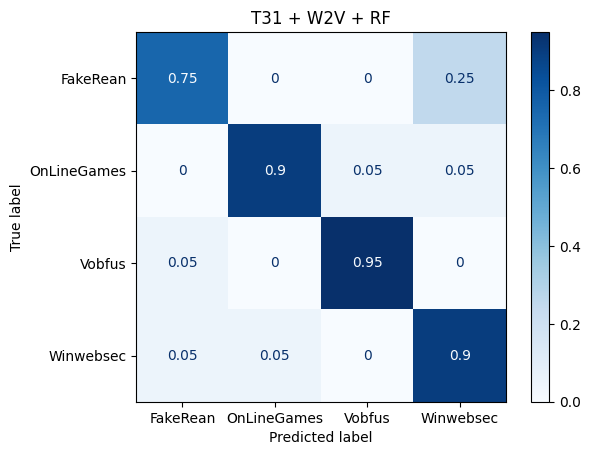

In [ ]:
# Single Word: M=31 + W2V
T31_rf, T31_rf_pred = fitRF(T31_train_w2v, T31_test_w2v, T31_y_train)
train_acc(T31_rf, T31_train_w2v, T31_y_train)
measures(T31_rf_pred, T31_y_test, 'T31 + W2V + RF')

train_accuracy: 100.0%
F1: 81.46%
Precision: 84.01%
Recall: 81.25%
Accuracy: 81.25%
[[15  0  0  5]
 [ 5 13  0  2]
 [ 0  0 20  0]
 [ 3  0  0 17]]


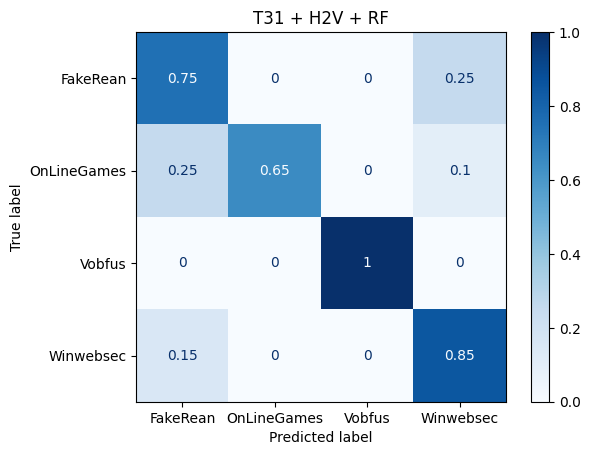

In [ ]:
# Single Word: M=31 + H2V
T31_rf_h2v, T31_rf_h2v_pred = fitRF(T31_train_h2v, T31_test_h2v, T31_y_train)
train_acc(T31_rf_h2v, T31_train_h2v, T31_y_train)
measures(T31_rf_h2v_pred, T31_y_test, 'T31 + H2V + RF')

#### Character BPE

train_accuracy: 100.0%
F1: 87.64%
Precision: 88.67%
Recall: 87.5%
Accuracy: 87.5%
[[15  0  0  5]
 [ 1 17  0  2]
 [ 0  0 20  0]
 [ 1  1  0 18]]


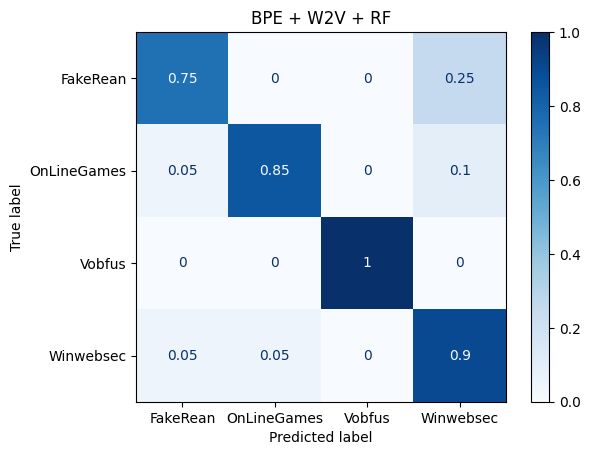

In [ ]:
# BPE + W2V
BPE_rf, BPE_rf_pred = fitRF(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
train_acc(BPE_rf, BPE_train_w2v, BPE_y_train)
measures(BPE_rf_pred, BPE_y_test, 'BPE + W2V + RF')

train_accuracy: 100.0%
F1: 86.16%
Precision: 89.46%
Recall: 86.25%
Accuracy: 86.25%
[[16  0  0  4]
 [ 2 13  0  5]
 [ 0  0 20  0]
 [ 0  0  0 20]]


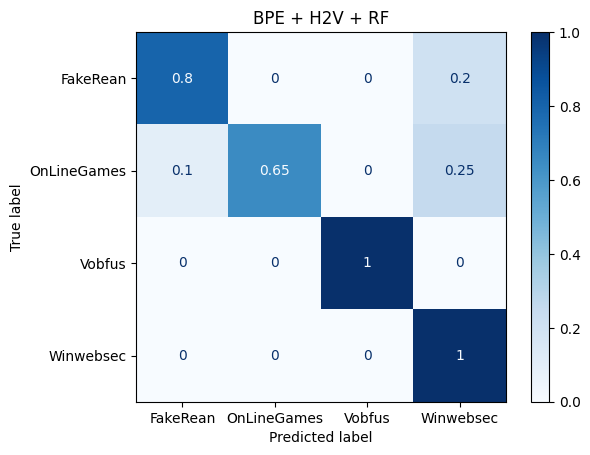

In [ ]:
# BPE + H2V
BPE_rf_h2v, BPE_rf_h2v_pred = fitRF(BPE_train_h2v, BPE_test_h2v, BPE_y_train)
train_acc(BPE_rf_h2v, BPE_train_h2v, BPE_y_train)
measures(BPE_rf_h2v_pred, BPE_y_test, 'BPE + H2V + RF')

####WordPiece

train_accuracy: 100.0%
F1: 91.33%
Precision: 92.01%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 1  0  0 19]]


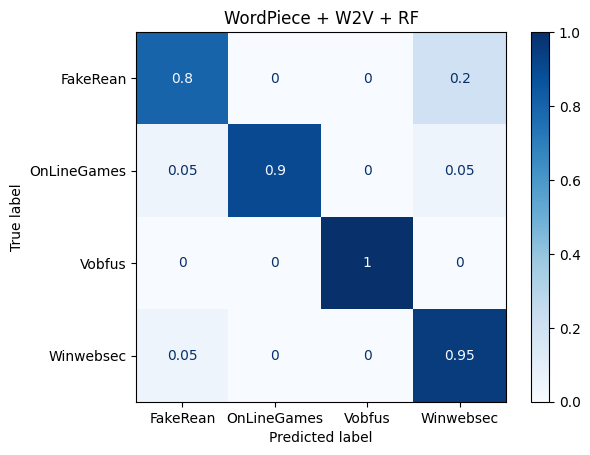

In [ ]:
# WPC
WPC_rf, WPC_rf_pred = fitRF(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
train_acc(WPC_rf, WPC_train_w2v, WPC_y_train)
measures(WPC_rf_pred, WPC_y_test, 'WPC + W2V + RF')

####SentencePiece

train_accuracy: 100.0%
F1: 91.42%
Precision: 92.53%
Recall: 91.25%
Accuracy: 91.25%
[[16  0  0  4]
 [ 0 18  0  2]
 [ 0  0 20  0]
 [ 1  0  0 19]]


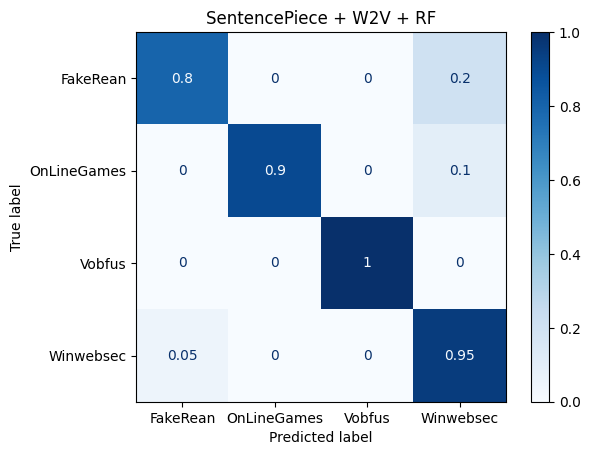

In [ ]:
# SPC
SPC_rf, SPC_rf_pred = fitRF(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
train_acc(SPC_rf, SPC_train_w2v, SPC_y_train)
measures(SPC_rf_pred, SPC_y_test, 'SPC + W2V + RF')

####Unigram Subword

train_accuracy: 100.0%
F1: 83.68%
Precision: 83.67%
Recall: 83.75%
Accuracy: 83.75%
[[16  2  0  2]
 [ 1 16  1  2]
 [ 1  0 19  0]
 [ 1  2  1 16]]


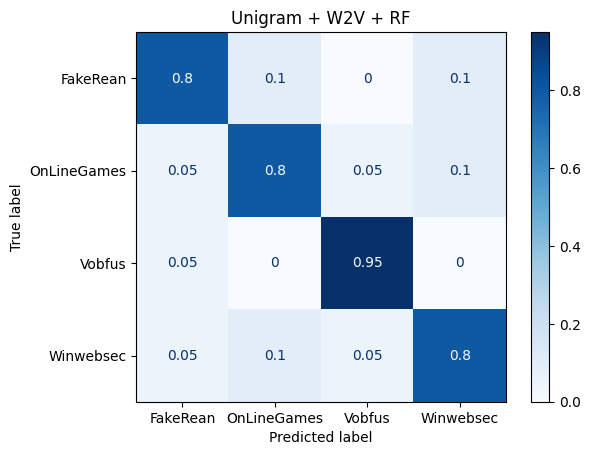

In [ ]:
# UNI
UNI_rf, UNI_rf_pred = fitRF(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
train_acc(UNI_rf, UNI_train_w2v, UNI_y_train)
measures(UNI_rf_pred, UNI_y_test, 'UNI + W2V + RF')

### KNN: K-Nearest Neighbors

In [ ]:
def fitKNN(train, test, y_train):
  clf = KNeighborsClassifier(n_neighbors=70)
  if type(train) == pd.Series:
    train = train.to_list()
    y_train = y_train.to_list()
    test = test.to_list()
  clf.fit(train, y_train)
  y_pred = clf.predict(test)
  return clf, y_pred

####Single Words M=31

F1: 64.26%
Precision: 67.45%
Recall: 63.75%
Accuracy: 63.75%
[[14  3  0  3]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 3  1  1 15]]


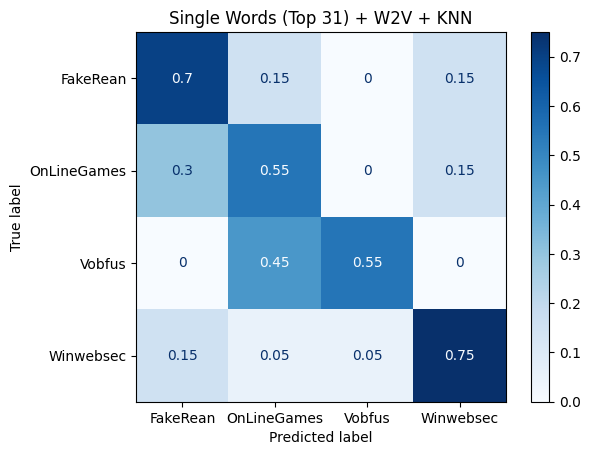

In [ ]:
# Single Words M=31
T31_knn, T31_knn_pred = fitKNN(T31_train_w2v, T31_test_w2v, T31_y_train)
measures(T31_knn_pred, T31_y_test, 'T31 + W2V + KNN')

#### BPE: Byte Pair Encoding

F1: 54.62%
Precision: 58.91%
Recall: 53.75%
Accuracy: 53.75%
[[12  5  0  3]
 [ 7 11  0  2]
 [ 0  9 11  0]
 [ 8  1  2  9]]


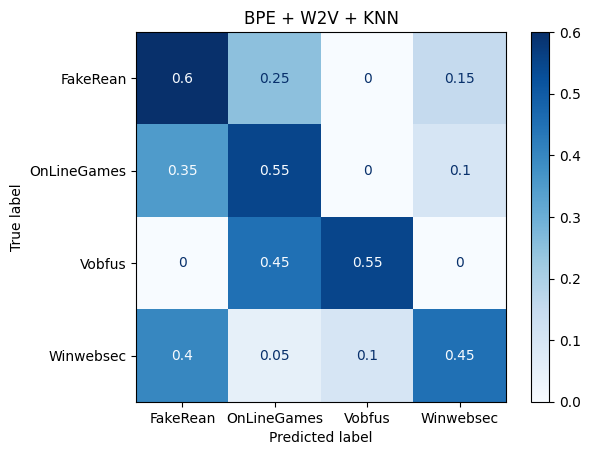

In [ ]:
# BPE
BPE_knn, BPE_knn_pred = fitKNN(BPE_train_w2v, BPE_test_w2v, BPE_y_train)
measures(BPE_knn_pred, BPE_y_test, 'BPE + W2V + KNN')

####WordPiece

F1: 57.32%
Precision: 61.24%
Recall: 56.25%
Accuracy: 56.25%
[[11  5  0  4]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 6  1  1 12]]


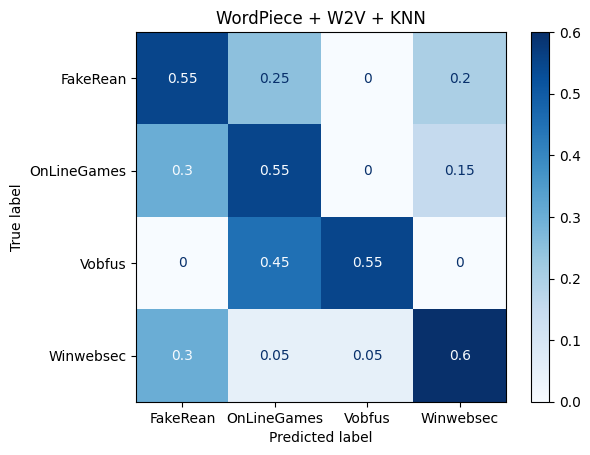

In [ ]:
# WPC
WPC_knn, WPC_knn_pred = fitKNN(WPC_train_w2v, WPC_test_w2v, WPC_y_train)
measures(WPC_knn_pred, WPC_y_test, 'WPC + W2V + KNN')

####SentencePiece

F1: 59.91%
Precision: 64.7%
Recall: 58.75%
Accuracy: 58.75%
[[13  4  0  3]
 [ 8 11  0  1]
 [ 0  9 11  0]
 [ 6  1  1 12]]


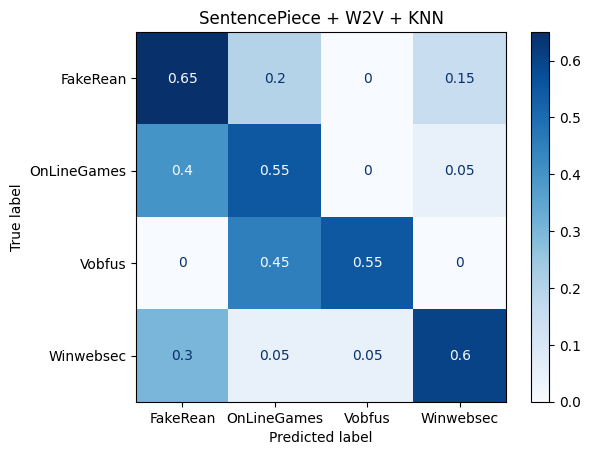

In [ ]:
# SPC
SPC_knn, SPC_knn_pred = fitKNN(SPC_train_w2v, SPC_test_w2v, SPC_y_train)
measures(SPC_knn_pred, SPC_y_test, 'SPC + W2V + KNN')

####Unigram Subword

F1: 55.74%
Precision: 58.86%
Recall: 55.0%
Accuracy: 55.0%
[[12  4  0  4]
 [ 6 11  0  3]
 [ 0  9 11  0]
 [ 7  1  2 10]]


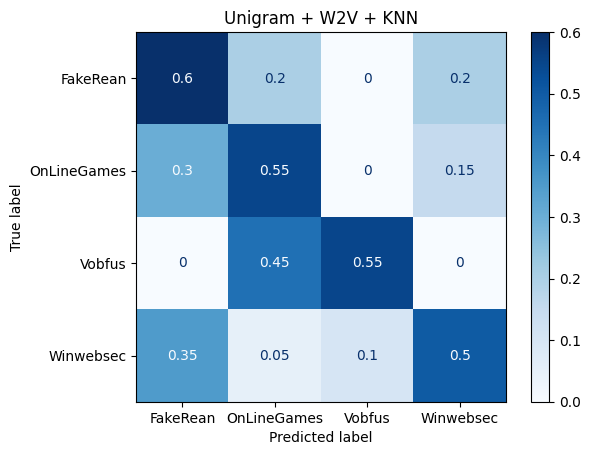

In [ ]:
# UNI
UNI_knn, UNI_knn_pred = fitKNN(UNI_train_w2v, UNI_test_w2v, UNI_y_train)
measures(UNI_knn_pred, UNI_y_test, 'UNI + W2V + KNN')

###SVM: Support Vector Machine###

In [ ]:
# REMEMBER TO CHANGE W2V embedding window=10, vector_size=31
def fitSVM(train, test, y_train, svm_type):
    clf = SVC(kernel=svm_type)
    if type(train) == pd.Series:
      train = train.to_list()
      y_train = y_train.to_list()
      test = test.to_list()
    clf.fit(train, y_train)
    y_pred = clf.predict(test)
    return clf, y_pred

####RBF SVM

##### Single Words M=31

F1: 78.37%
Precision: 80.05%
Recall: 78.75%
Accuracy: 78.75%
[[16  0  0  4]
 [ 6 11  1  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


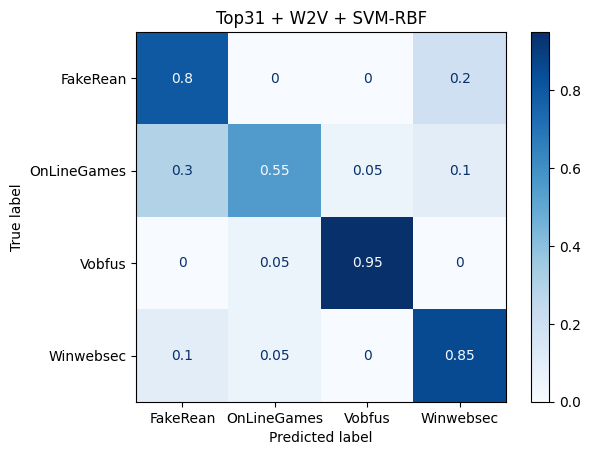

In [ ]:
# Single Words M=31; RBF SVM
T31_svm_rbf, T31_svm_pred_rbf = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'rbf')
measures(T31_svm_pred_rbf, T31_y_test, 'T31 + W2V + SVM-RBF')

#####BPE

F1: 78.77%
Precision: 80.44%
Recall: 78.75%
Accuracy: 78.75%
[[15  0  0  5]
 [ 6 12  0  2]
 [ 0  1 19  0]
 [ 2  1  0 17]]


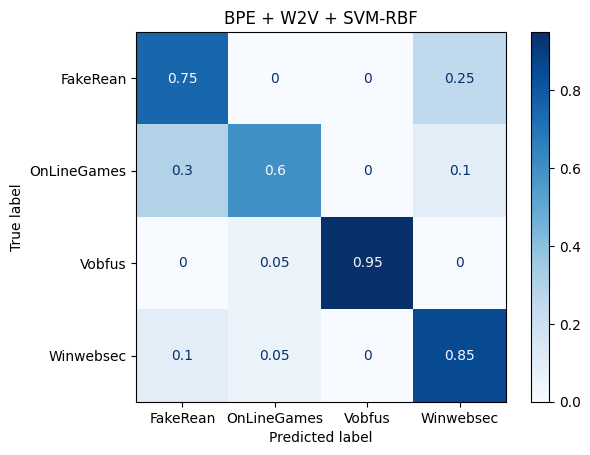

In [ ]:
# BPE
BPE_svm_rbf, BPE_svm_pred_rbf = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'rbf')
measures(BPE_svm_pred_rbf, BPE_y_test, 'BPE + W2V + SVM-RBF')

#####WordPiece

F1: 79.66%
Precision: 81.57%
Recall: 80.0%
Accuracy: 80.0%
[[17  0  0  3]
 [ 5 11  0  4]
 [ 0  1 19  0]
 [ 2  1  0 17]]


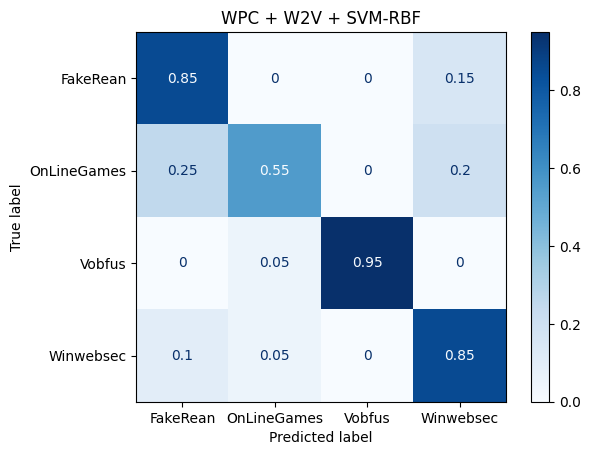

In [ ]:
# WPC
WPC_svm_rbf, WPC_svm_pred_rbf = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'rbf')
measures(WPC_svm_pred_rbf, WPC_y_test, 'WPC + W2V + SVM-RBF')

#####SentencePiece

F1: 83.63%
Precision: 84.71%
Recall: 83.75%
Accuracy: 83.75%
[[17  0  0  3]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


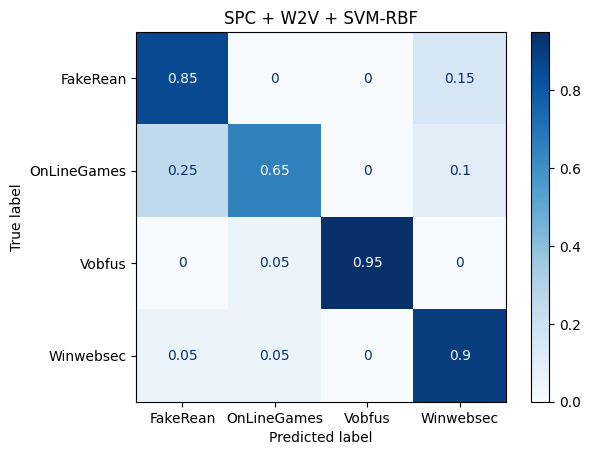

In [ ]:
# SPC
SPC_svm_rbf, SPC_svm_pred_rbf = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'rbf')
measures(SPC_svm_pred_rbf, SPC_y_test, 'SPC + W2V + SVM-RBF')

#####Unigram Subword

F1: 82.43%
Precision: 83.6%
Recall: 82.5%
Accuracy: 82.5%
[[16  0  0  4]
 [ 5 13  0  2]
 [ 0  1 19  0]
 [ 1  1  0 18]]


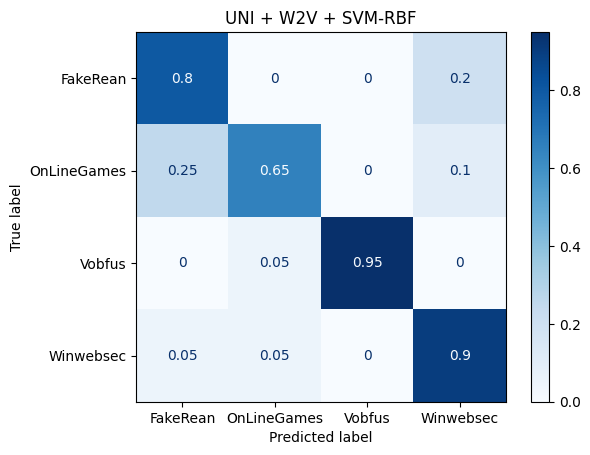

In [ ]:
# UNI
UNI_svm_rbf, UNI_svm_pred_rbf = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'rbf')
measures(UNI_svm_pred_rbf, UNI_y_test, 'UNI + W2V + SVM-RBF')

####Linear SVM

#####Single Words M=31

F1: 92.38%
Precision: 92.68%
Recall: 92.5%
Accuracy: 92.5%
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  0 20  0]
 [ 2  1  1 16]]


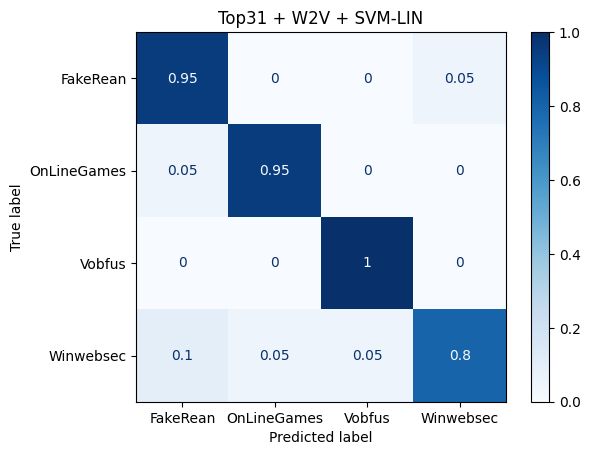

In [ ]:
# Single Words M=31; RBF SVM
T31_svm_lin, T31_svm_pred_lin = fitSVM(T31_train_w2v, T31_test_w2v, T31_y_train, 'linear')
measures(T31_svm_pred_lin, T31_y_test, 'T31 + W2V + SVM-LIN')

##### BPE

F1: 87.55%
Precision: 87.74%
Recall: 87.5%
Accuracy: 87.5%
[[17  1  0  2]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 3  1  0 16]]


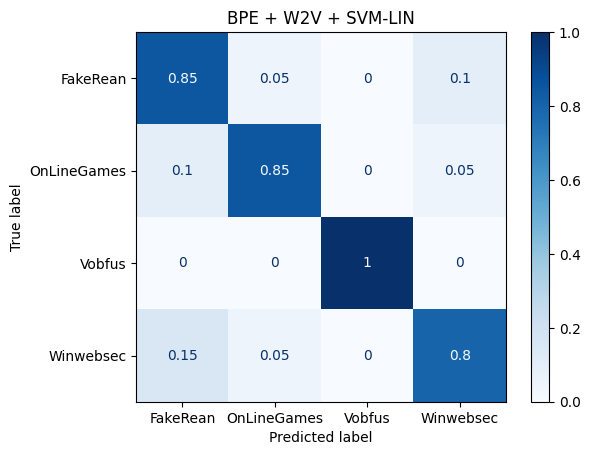

In [ ]:
# BPE
BPE_svm_lin, BPE_svm_pred_lin = fitSVM(BPE_train_w2v, BPE_test_w2v, BPE_y_train, 'linear')
measures(BPE_svm_pred_lin, BPE_y_test, 'BPE + W2V + SVM-LIN')

#####WordPiece

F1: 83.75%
Precision: 84.25%
Recall: 83.75%
Accuracy: 83.75%
[[18  0  0  2]
 [ 2 16  0  2]
 [ 0  1 19  0]
 [ 4  2  0 14]]


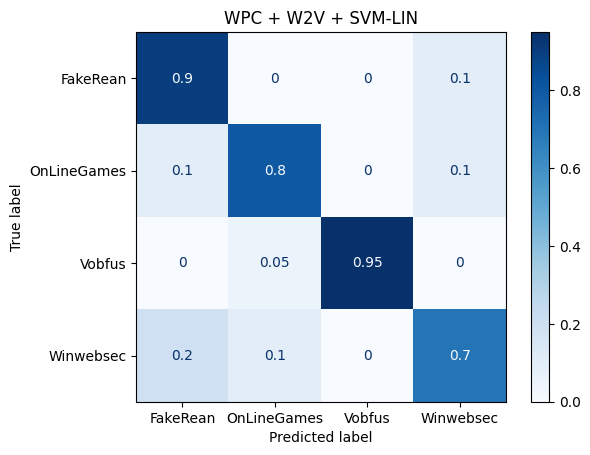

In [ ]:
# WPC
WPC_svm_lin, WPC_svm_pred_lin = fitSVM(WPC_train_w2v, WPC_test_w2v, WPC_y_train, 'linear')
measures(WPC_svm_pred_lin, WPC_y_test, 'WPC + W2V + SVM-LIN')

#####SentencePiece

F1: 86.37%
Precision: 86.83%
Recall: 86.25%
Accuracy: 86.25%
[[17  0  0  3]
 [ 2 17  0  1]
 [ 0  0 20  0]
 [ 4  1  0 15]]


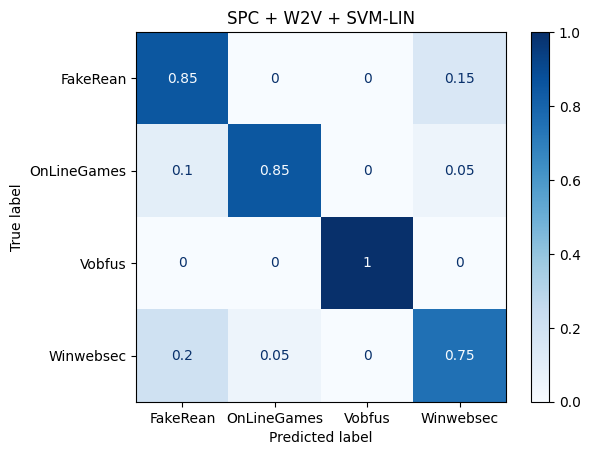

In [ ]:
# SPC
SPC_svm_lin, SPC_svm_pred_lin = fitSVM(SPC_train_w2v, SPC_test_w2v, SPC_y_train, 'linear')
measures(SPC_svm_pred_lin, SPC_y_test, 'SPC + W2V + SVM-LIN')

#####Unigram Subword

F1: 90.06%
Precision: 90.17%
Recall: 90.0%
Accuracy: 90.0%
[[17  0  0  3]
 [ 1 18  0  1]
 [ 0  0 20  0]
 [ 2  1  0 17]]


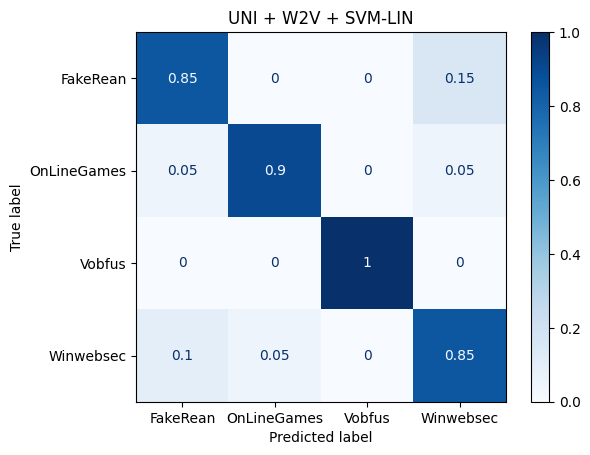

In [ ]:
# UNI
UNI_svm_lin, UNI_svm_pred_lin = fitSVM(UNI_train_w2v, UNI_test_w2v, UNI_y_train, 'linear')
measures(UNI_svm_pred_lin, UNI_y_test, 'UNI + W2V + SVM-LIN')

### CNN

In [ ]:
# CNN: Data 80/10/10 train/val/test split
# input layer dim=200; hidden=500, output=7
# train 50 epochs, MSE loss, Adam optimizer, dropout 0.5
# learning rate = 0.001
# beta1 = 0.9; beta2 = 0.999
# N (vector size)=100, Window=5 for w2v

model = models.Sequential([
    layers.Input(shape=(320, (100))),
    layers.Conv1D(500, (1), activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
# compile model
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 320, 500)          50500     
                                                                 
 dropout_18 (Dropout)        (None, 320, 500)          0         
                                                                 
 dense_18 (Dense)            (None, 320, 7)            3507      
                                                                 
Total params: 54007 (210.96 KB)
Trainable params: 54007 (210.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# T31_train_w2v = tf.convert_to_tensor(T31_train_w2v)
# T31_test_w2v = np.asarray(T31_test_w2v)
# T31_y_train = np.asarray(T31_y_train)
# T31_y_test = np.asarray(T31_y_test)

# model.fit(T31_train_w2v.tolist(), T31_y_train.tolist(), epochs=5, validation_split=0.1)
# model.fit(T31_train_w2v, T31_y_train, epochs=5)

print(T31_train_w2v.shape)
print(T31_train_w2v)
# model.fit(x_train, y_train, epochs=5)
# test_loss, test_acc = model.evaluate(T31_test_w2v, T31_y_test)
# print(test_loss, test_acc)
# T31_cnn_pred = model.predict(T31_test_w2v)
# model.summary()

# model, pred = fitCNN(train_embeddings, test_embeddings, train_labels)
# measures(pred, test_embeddings 'T31 + W2V + CNN')

(320,)
